Image Classification with TensorFlow:

We will be using the `CIFAR-10` data set.  It consists of 60,000 images, each $32\times32$ color pixels, each belonging to one of ten classes. 

In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train=x_train/256.0
x_test=x_test/256.0

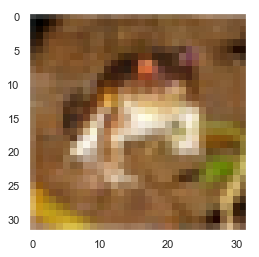

In [4]:
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(x_train[0])

In [5]:
x_train[0].shape

(32, 32, 3)

In [84]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
import tensorflow as tf

sess = None

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

def reset_vars():
    sess.run(tf.global_variables_initializer())
    
reset_tf()

Perceptual Delta:

In [7]:
def delta_func(images, base):
    Ni,Nx,Ny,Nc=images.shape
    dR=tf.subtract(images[0:Ni,:,:,0], base[:,:,0])
    dG=tf.subtract(images[0:Ni,:,:,1], base[:,:,1])
    dB=tf.subtract(images[0:Ni,:,:,2], base[:,:,2])
    bR=tf.add(images[0:Ni,:,:,0], base[:,:,0])/2
    dC=(2*dR**2+4*dG**2+3*dB**2+bR*(dR**2-dB**2))**0.5
    dC=tf.reduce_mean(dC, axis=(1,2),)
#    dC=dC.mean(axis=(1,2))
    return dC

In [14]:
Ni,Nx,Ny,Nc=x_train.shape
images = tf.placeholder(tf.float32, shape=(None,Nx,Ny,Nc))
base = tf.placeholder(tf.float32, shape=(Nx,Ny,Nc))
with tf.Session() as sess:
    deltas = sess.run(delta_func(images,base), feed_dict={images: x_train,base:x_train[0]})

x_test[0].shape

(32, 32, 3)

In [15]:
x_test[0].shape

(32, 32, 3)

In [16]:
deltas[1]

0.8028495

In [17]:
import numpy as np
np.argsort(deltas)[:100]

array([    0, 45702, 16244, 42549, 35877, 48216, 15673, 33378, 28732,
       16603, 30466, 13972, 24646, 21167,  5583,  5017,  5166, 43118,
        1184, 11582, 28594,  4637,    58, 10034, 16463, 46423, 42291,
       15160, 24531, 14553,  6636,  7690, 41272, 19420,  9762,  9980,
       48160, 36396, 39508, 14275, 49577, 38967, 33069, 44910, 12060,
       35148, 46049, 14060, 19781, 46968, 34580,   692, 12003, 45739,
       23064,  3944, 47631, 34777, 44207, 45721, 30041, 48243, 18251,
        4805, 10958, 47846, 49364,  6940, 48937, 46539, 40610,  9087,
       20439,  2654, 48447, 13770, 46800, 23698, 37865, 39452,  7277,
        3797, 11254, 48804, 45334,  6548, 36112, 16478,  5111, 45801,
        1968, 41749, 40473, 29097, 48208, 27478, 14857, 15578, 28600,
        6461], dtype=int64)

Smallest delta model using an average(typical) image:

In [19]:
Ni,Nx,Ny,Nc=x_test.shape
typical=tf.Variable(tf.random_normal([Nx,Ny,Nc], stddev=.5, mean=.5)/2, dtype=np.float32)
#typical = tf.Variable((((.5**2)*(np.random.randn(Nx,Ny,Nc))+1)/2), dtype=np.float32).initialized_value()typical = tf.Variable(...)

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
def reset_vars():
    sess.run(tf.global_variables_initializer())

In [24]:
Ni,Nx,Ny,Nc=x_train.shape
img = tf.placeholder(tf.float32, shape=(None,Nx,Ny,Nc))
error = tf.reduce_mean(delta_func(img,typical))

In [27]:
label = 6
Ni,Nx,Ny,Nc=x_train.shape
index=[]
for i in range(Ni):
    if y_train[i]==label:
        index.append(i)
ims =x_train[index,:,:,:].astype('float32')

gradient descent optimizer:

In [28]:
import tensorflow as tf
eta = 1
optimizer=tf.train.AdamOptimizer(eta)
#optimizer = tf.train.GradientDescentOptimizer(eta)
train = optimizer.minimize(error)

Instructions for updating:
Use tf.cast instead.


In [29]:
with tf.Session() as sess:
    reset_vars()
    for _ in range(20):
        sess.run(train, feed_dict={img: ims})
    typical6=typical.eval()

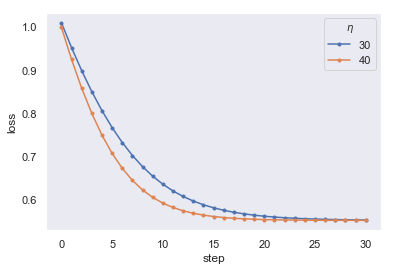

In [30]:
#best e=30, rnge(30)
etas = [30,40]
errors = []
BATCH_SIZE = 100
EPOCHS = 30
for e in etas:
    with tf.Session() as sess:
        reset_vars()
        #optimizer=tf.train.AdamOptimizer(e)
        optimizer = tf.train.GradientDescentOptimizer(e)  # learning rate
        train = optimizer.minimize(error)
        errors.append([sess.run(error, feed_dict={img: ims})])
        for i in range(EPOCHS):
            sess.run(train, feed_dict={img: ims})
            errors[-1].append(sess.run(error, feed_dict={img: ims}))
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import expectexception
plt.plot(np.array(errors).T, '.-')
plt.legend(etas, title=r'$\eta$')
plt.xlabel('step')
plt.ylabel('loss');

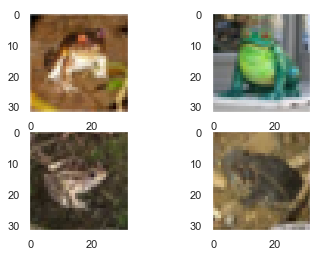

In [108]:
frogs = np.where(train_labels == 6)[0]   #  Get the indices for the frogs

fig, ax = matplotlib.pyplot.subplots(2, 2)
for i in range(4):
    np.ravel(ax)[i].imshow(train_images[ frogs[i] ])

matplotlib.pyplot.show()

Convolutional model:

In [36]:
from tensorflow.keras.utils import to_categorical as one_hot
# Parameters
learning_rate = 0.1
num_steps = 500
batch_size = 200
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 32*32*3 # MNIST data input (img shape: 32*32)
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

X_train1=x_train.reshape(len(x_train), -1)
X_test1=x_test.reshape(len(x_test), -1)

y_train1 = one_hot(y_train)
#y_test1  = one_hot(y_test)


def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Create model
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Construct model
logits = neural_net(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
#        batch_x, batch_y = mnist.train.next_batch(batch_size)
        batch_x, batch_y=next_batch(batch_size,X_train1, y_train1)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for MNIST test images
#    print("Testing Accuracy:", \
#        sess.run(accuracy, feed_dict={X: mnist.test.images,
#                                      Y: mnist.test.labels}))

Step 1, Minibatch Loss= 115193.8594, Training Accuracy= 0.070
Step 100, Minibatch Loss= 14627.1240, Training Accuracy= 0.120
Step 200, Minibatch Loss= 873.4044, Training Accuracy= 0.290
Step 300, Minibatch Loss= 232.7632, Training Accuracy= 0.340
Step 400, Minibatch Loss= 120.9584, Training Accuracy= 0.250
Step 500, Minibatch Loss= 93.6843, Training Accuracy= 0.265
Optimization Finished!


using keras:

In [37]:
#keras
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import time
from datetime import datetime, timedelta
#import pylib
#import pylib.conv_widget as cw
#from pylib.tensorboardcmd import tensorboard_cmd
from tensorflow.keras.utils import to_categorical as one_hot

X_train1=x_train.reshape(len(x_train), -1)
X_test1=x_test.reshape(len(x_test), -1)
#X_train=x_train
#X_test=x_test
y_train_2 = one_hot(y_train)
y_test_2  = one_hot(y_test)

img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 1
filt_size = [5, 5] # 5x5 pixel filters

batch_size = 100
n_epochs = 1
model = keras.models.Sequential()

model.add(keras.layers.Reshape([img_size, img_size, 3]))
model.add(keras.layers.Conv2D(16, filt_size, padding='same',
                              activation='relu'))
#                            activation='softmax'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='valid'))#padding='same'))
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(1024, activation='sigmoid'))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(n_classes, activation='softmax'))
#model.add(keras.layers.Dense(n_classes, activation='sigmoid'))
#model.add(keras.layers.Dense(n_classes, activation='relu'))
#model.compile(loss='mean_squared_error',
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=.1),
#optimizer=keras.optimizers.Adam(lr=0.01), #works with relu
              metrics=['accuracy'],
              target_tensors=[y_train_2])

history = model.fit(X_train1, y_train_2,
                    epochs=n_epochs,
                    batch_size=batch_size)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
50000/50000 [==============================] - 36s 728us/sample - loss: 1.9159 - acc: 0.3085


In [9]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 4s 363us/sample - loss: 147.4514 - acc: 0.0710


[147.45144267578124, 0.071]

convolution model:

In [19]:
#convolution
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import time
from datetime import datetime, timedelta
#import pylib
#import pylib.conv_widget as cw
#from pylib.tensorboardcmd import tensorboard_cmd
from tensorflow.keras.utils import to_categorical as one_hot

#X_train=train_images.reshape(len(train_images), -1)
#X_test=validation_images.reshape(len(validation_images), -1)
X_train=x_train
X_test=x_test
y_train_2 = one_hot(y_train)
y_test_2  = one_hot(y_test)

img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 1
filt_size1 = [3, 3] 
filt_size2 = [5, 5] # 5x5 pixel filters

batch_size = 50
n_epochs = 8
model = keras.models.Sequential()

#model.add(keras.layers.Reshape([img_size, img_size, 3]))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Conv2D(32, filt_size1, padding='same',
                              activation='relu'))
#                            activation='softmax'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='valid'))#padding='same'))
model.add(keras.layers.Conv2D(64, filt_size2, padding='same',
                              activation='relu'))
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(1024, activation='sigmoid'))
#model.add(keras.layers.Dense(1024, activation='relu'))
#model.add(keras.layers.Dense(1024, activation='relu'))
#model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(n_classes, activation='softmax'))
#model.add(keras.layers.Dense(n_classes, activation='sigmoid'))
#model.add(keras.layers.Dense(n_classes, activation='relu'))
#model.compile(loss='mean_squared_error',
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=.1),
#              optimizer=keras.optimizers.Adam(lr=0.01), #works with relu
              metrics=['accuracy'],
              target_tensors=[y_train_2])

history = model.fit(X_train, y_train_2,
                    epochs=n_epochs,
                    batch_size=batch_size,
                   validation_data=(X_test, y_test_2))

Train on 50000 samples, validate on 10000 samples
Train on 50000 samples, validate on 10000 samples
Epoch 1/8
Epoch 1/8
50000/50000 [==============================] - 75s 2ms/sample - loss: 1.9153 - acc: 0.3168 - val_loss: 1.7765 - val_acc: 0.3734
Epoch 2/8
50000/50000 [==============================] - 74s 1ms/sample - loss: 1.4286 - acc: 0.4960 - val_loss: 1.2839 - val_acc: 0.5476
Epoch 3/8
50000/50000 [==============================] - 74s 1ms/sample - loss: 1.1865 - acc: 0.5860 - val_loss: 1.0687 - val_acc: 0.6284
Epoch 4/8
50000/50000 [==============================] - 74s 1ms/sample - loss: 1.0363 - acc: 0.6407 - val_loss: 1.0422 - val_acc: 0.6417
Epoch 5/8
50000/50000 [==============================] - 73s 1ms/sample - loss: 0.9242 - acc: 0.6811 - val_loss: 0.9412 - val_acc: 0.6798
Epoch 6/8
50000/50000 [==============================] - 73s 1ms/sample - loss: 0.8505 - acc: 0.7057 - val_loss: 0.9277 - val_acc: 0.6811
Epoch 7/8
50000/50000 [==============================] - 73s 1